# Flood segmentation

Using a Kaggle dataset: [ETCi 2021 Competition on Flood Detection](https://www.kaggle.com/datasets/aninda/etci-2021-competition-on-flood-detection) ([NASA contest](https://nasa-impact.github.io/etci2021/))

* Objective: delineate open water flood areas as an effort to identify flood extent.
* Data: synthetic aperture radar (SAR) images.
* Performance: evaluated using the intersection over union (IOU) score.

SAR imagery: signal is based on surface characteristics like structure and moisture (https://earthdata.nasa.gov/learn/backgrounders/what-is-sar). SAR sensors transmit linearly polarized: 
* Horizontal polarization = H
* Vertical polarization = V.

## Setup

### Import necessary modules and do some basic setup.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import os
import glob
import numpy as np
from pathlib import Path

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Pytorch and other stuff
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.functional import F
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import skimage.io
from sklearn.metrics import jaccard_score

In [2]:
# Paths
DATAPATH = Path("C:/Users/morph/Documents/Pascal/ML-floods/SAR-Flood-Segmentation")

In [3]:
# Options
BATCH_SIZE = 32

### Helper functions

In [4]:
def show_images(**images):
    """Show the provided images in a single row."""
    n_rows = len(images)
    plt.figure(figsize=(18, 6))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_rows, i + 1)
        plt.axis('off')
        plt.title(' '.join(name.split('_')))
        plt.imshow(image)
    plt.show()


def show_train_event(event, tile):
    """Show the tiles for a given event in the train period."""
    flood_label = skimage.io.imread(DATAPATH / "train" / "train" / event / "tiles" / "flood_label" / f"{event}_{tile}.png")
    water_body_label = skimage.io.imread(DATAPATH / "train" / "train" / event / "tiles" / "water_body_label" / f"{event}_{tile}.png")
    vv = skimage.io.imread(DATAPATH / "train" / "train" / event / "tiles" / "vv" / f"{event}_{tile}_vv.png")
    vh = skimage.io.imread(DATAPATH / "train" / "train" / event / "tiles" / "vh" / f"{event}_{tile}_vh.png")

    show_images(vv=vv, vh=vh, water_body_label=water_body_label, flood_label=flood_label)


def get_image_paths(base_dir):
    """Get the paths of the images and label in a consistant way."""
    vh_files = sorted(list(base_dir.glob('**/vh/*.png')))
    vv_files = sorted(list(base_dir.glob('**/vv/*.png')))
    # Need to handle the label files differently as the sorted() function returns another order.
    label_files = [Path(str(x).replace('tiles/vh', 'tiles/flood_label')
                              .replace('tiles\\vh', 'tiles\\flood_label')
                              .replace('_vh', '')) for x in vh_files]
    
    return [vh_files, vv_files, label_files]


## Data

66,810 (33,405 x 2 VV & VH polarization) tiles of 256×256 pixels:
* training: 33,405 
* validation: 10,400
* test: 12,348 tiles

Sentinel-1 C-band synthetic aperture radar (SAR) imagery. VV & VH polarizations available
* VV = Signals emitted in vertical (V) and received in vertical (V) polarization 
* VH = Signals emitted in vertical (V) and received in horizontal (H) polarization

Signal strength from these different polarizations (https://earthdata.nasa.gov/learn/backgrounders/what-is-sar):
* Rough surface scattering, such as that caused by bare soil or water, is most sensitive to VV scattering.
* Volume scattering, for example, caused by the leaves and branches in a forest canopy, is most sensitive to cross-polarized data like VH or HV.

29 different flood events in 5 different regions. 4 sub-folders: vv, vh, flood_label and water_body_label


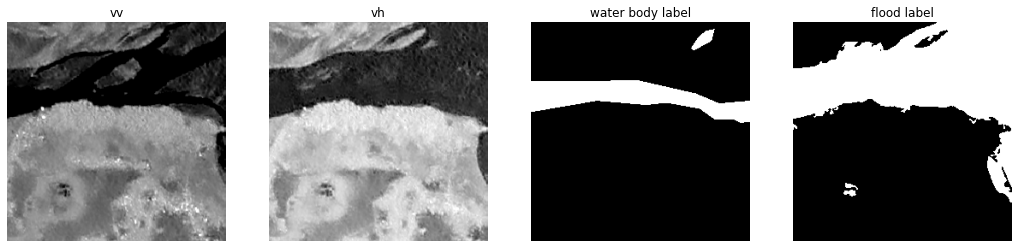

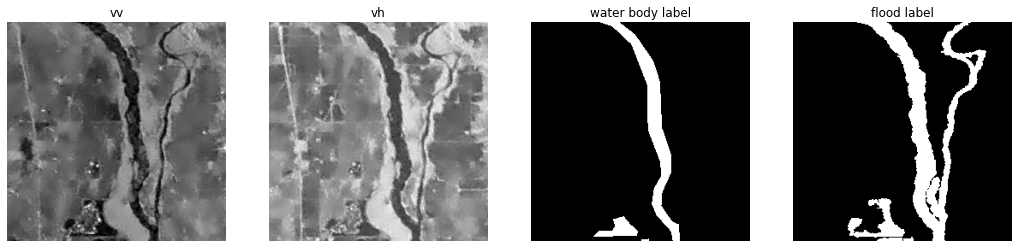

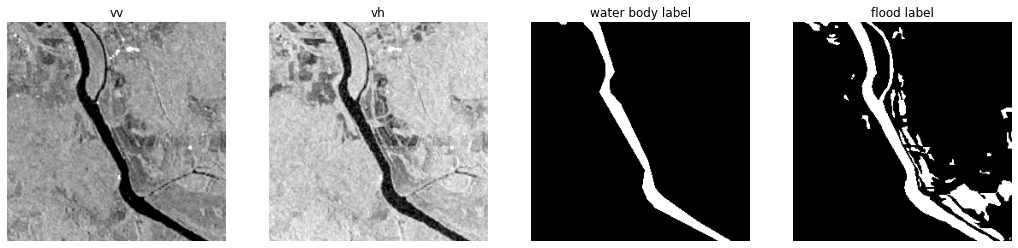

In [5]:
show_train_event(event="bangladesh_20170314t115609", tile="x-5_y-33")
show_train_event(event="nebraska_20170508t002113", tile="x-5_y-20")
show_train_event(event="northal_20190618t234654", tile="x-14_y-22")

### File lists

In [6]:
# Get lists of files
[train_vh_files, train_vv_files, train_label_files] = get_image_paths(DATAPATH / "train")
[valid_vh_files, valid_vv_files, valid_label_files] = get_image_paths(DATAPATH / "val_with_ref_labels")

uint8


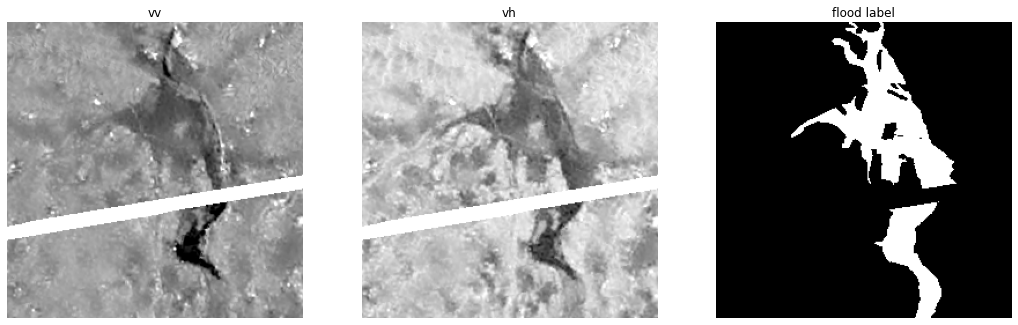

In [7]:
# Type is OK
print(skimage.io.imread(train_vh_files[0]).dtype)

idx = 750
show_images(vv=skimage.io.imread(train_vv_files[idx]), 
            vh=skimage.io.imread(train_vh_files[idx]), 
            flood_label=skimage.io.imread(train_label_files[idx]))

## Dataset

In [8]:
class Floods(Dataset):
    def __init__(self, vh_paths, vv_paths, label_paths):
        super(Floods, self).__init__()
        
        self.vh_paths = vh_paths
        self.vv_paths = vv_paths
        self.label_paths = label_paths
        
    def __getitem__(self, index):
        
        # Load and convert both images
        vh = skimage.io.imread(self.vh_paths[index])
        vh = torch.tensor(vh/255, dtype=torch.float32)
        vv = skimage.io.imread(self.vv_paths[index])
        vv = torch.tensor(vv/255, dtype=torch.float32)

        # Combine the bands into 6-bands images
        x = torch.cat((vh, vv), 2)
        
        # Move channel to first position
        x = x.permute(2, 0, 1)

        # Load lables
        y = skimage.io.imread(self.label_paths[index])
        #y = torch.tensor(y, dtype=torch.int64)
        y = torch.tensor(y, dtype=torch.float32)

        # Onky keep one channel for the label
        y = y[:,:,0]
        y = torch.unsqueeze(y, dim=0)
        
        return x, y, 

    def __len__(self):

        return len(self.vh_paths)

In [9]:
# Get dataset and data loader
train_data = Floods(train_vh_files, train_vv_files, train_label_files)
valid_data = Floods(valid_vh_files, valid_vv_files, valid_label_files)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE)
validation_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)

In [10]:
# Check shapes
test_image, test_label = next(iter(train_loader))
print(f"Input image size: {test_image.shape}")
print(f"Output size: {test_label.shape}")

Input image size: torch.Size([32, 6, 256, 256])
Output size: torch.Size([32, 1, 256, 256])


## Unet

In [11]:
class Unet(pl.LightningModule):
    def __init__(self, num_classes, learning_rate):
        super(Unet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.transpose_conv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, padding=0, stride=2)
        self.conv2_t = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.transpose_conv2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, padding=0, stride=2)
        self.conv1_t = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.conv_final = nn.Conv2d(in_channels=16, out_channels=num_classes, kernel_size=1)
        
        self.loss = nn.CrossEntropyLoss()
        
        self.learning_rate = learning_rate
        
    def forward(self, x):
        
        x1 = F.relu(self.conv1(x))
        x = self.maxpool1(x1)
        x2 = F.relu(self.conv2(x))
        x = self.maxpool2(x2)
        x3 = F.relu(self.conv3(x))
        x2_t = self.transpose_conv3(x3)
        x = torch.cat((x2, x2_t),dim=1)
        x = F.relu(self.conv2_t(x))
        x = self.transpose_conv2(x)
        x = torch.cat((x1, x),dim=1)
        x = F.relu(self.conv1_t(x))
        x = self.conv_final(x)

        #x = F.sigmoid(x)
        
        return x
        
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        loss = self.loss(output, y)
        
        #self.log("Loss/Train", loss, on_epoch=True, prog_bar=True, logger=True)
        self.logger.experiment.add_scalar("Loss/Train", loss, self.current_epoch)

        return loss
    
    def validation_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        output_proj = output.argmax(dim=1)
        jaccard = jaccard_score(y.view(-1), output_proj.view(-1), average='macro')

        #self.log("Jaccard/Valid", jaccard, on_epoch=True, prog_bar=True, logger=True)
        self.logger.experiment.add_scalar("Jaccard/Valid", jaccard, self.current_epoch)

        return jaccard
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        

## Training

In [12]:
# Options
EPOCHS = 30

In [13]:
unet = Unet(num_classes=1, learning_rate=1e-3)
logger = TensorBoardLogger("tb_logs", name="ml_floods")
trainer = pl.Trainer(max_epochs=EPOCHS, logger=logger)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(unet, train_dataloaders=train_loader, val_dataloaders=validation_loader)